In [73]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import math
from ipywidgets import interact, widgets

import skimage

from DiffuserCamUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [83]:
def initialize(image_file, psf_file, f_lat=1, f_ax=1, type='pco', color='rgb', dim='2d'):
    try:
        im_type = image_file[-3:]
        psf_type = psf_file[-3:]
        #image = rgb2gray(np.array(Image.open(image_file, mode='r')))
        image = np.sum(np.array(Image.open(image_file, mode='r')), 2)
        
        #psf = rgb2gray(np.array(Image.open(psf_file, mode='r')))
        psf = np.sum(np.array(Image.open(psf_file, mode='r')), 2)
        
    except IOError as ex:
        print("I/O error: " + str(ex.strerror))
    
    
    if dim == '2d':         #embed into a 3d array
        psf = np.expand_dims(psf, 2)
    print("max", np.max(image))    
    psf_bg = np.min(psf)
    image_bg = np.mean(image[5:15, 5:15])

    # Downsampling the images
    psf_down = skimage.transform.resize(psf - psf_bg, (psf.shape[0]//f_lat, psf.shape[1]//f_lat),
                                    mode="constant", anti_aliasing=True)
    image_down = skimage.transform.resize(image-psf_bg, (image.shape[0]//f_lat, image.shape[1]//f_lat),
                                    mode="constant", anti_aliasing=True)
    image_pad = np.mean(np.random.choice(image_down.flatten('C'),(15,15))) #102
    
    image_pad = np.mean(np.array(np.mean(image_down[:,0:10]), np.mean(image_down[0:10,:])))
    print("image pad" + str(image_pad))
    print(image_bg)
    # Padding the rawdata image
    padded = np.full(psf_down.shape[:2], image_pad)
    
    padded[psf_down.shape[0]//2 - image_down.shape[0]//2: psf_down.shape[0]//2 + image_down.shape[0]//2,
            psf_down.shape[1]//2 - image_down.shape[1]//2: psf_down.shape[1]//2 + image_down.shape[1]//2] = image_down
    image_down = padded
    
    if dim == '3d':
        psf_down = downsample_lat(psf_down, f_ax)

    psf_down /= norm(psf_down)
    image_down /= np.max(image_down)
    #image_down = np.true_divide(image_down, np.max(image_down))
    print(np.max(image_down))

    return psf_down, image_down


In [84]:
dimensions = '2d'
psf_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/recon_test/Transformed_PSF.png'
image_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/recon_test/img1.png'

psf, b = initialize(image_file, psf_file, dim = dimensions, f_lat = 2)
#psf -= np.min(psf)
#b -= np.min(psf)

r = 0.5    #proportion of pixels to crop out
num_cropped = int(r * b.size)
crop2d, crop3d, pad2d, pad3d, pix_crop = get_crop_pad(psf, N = num_cropped)
h = pad2d(psf)    #pad the input stack of h's

obj_shape = h.shape
up_shape = psf.shape
A, AH = get_ops(h, crop2d, pad2d, crop3d, pad3d, up_shape)

#

max 371
image pad4.064866390533772e-18
341.16
1.0


<IPython.core.display.Javascript object>


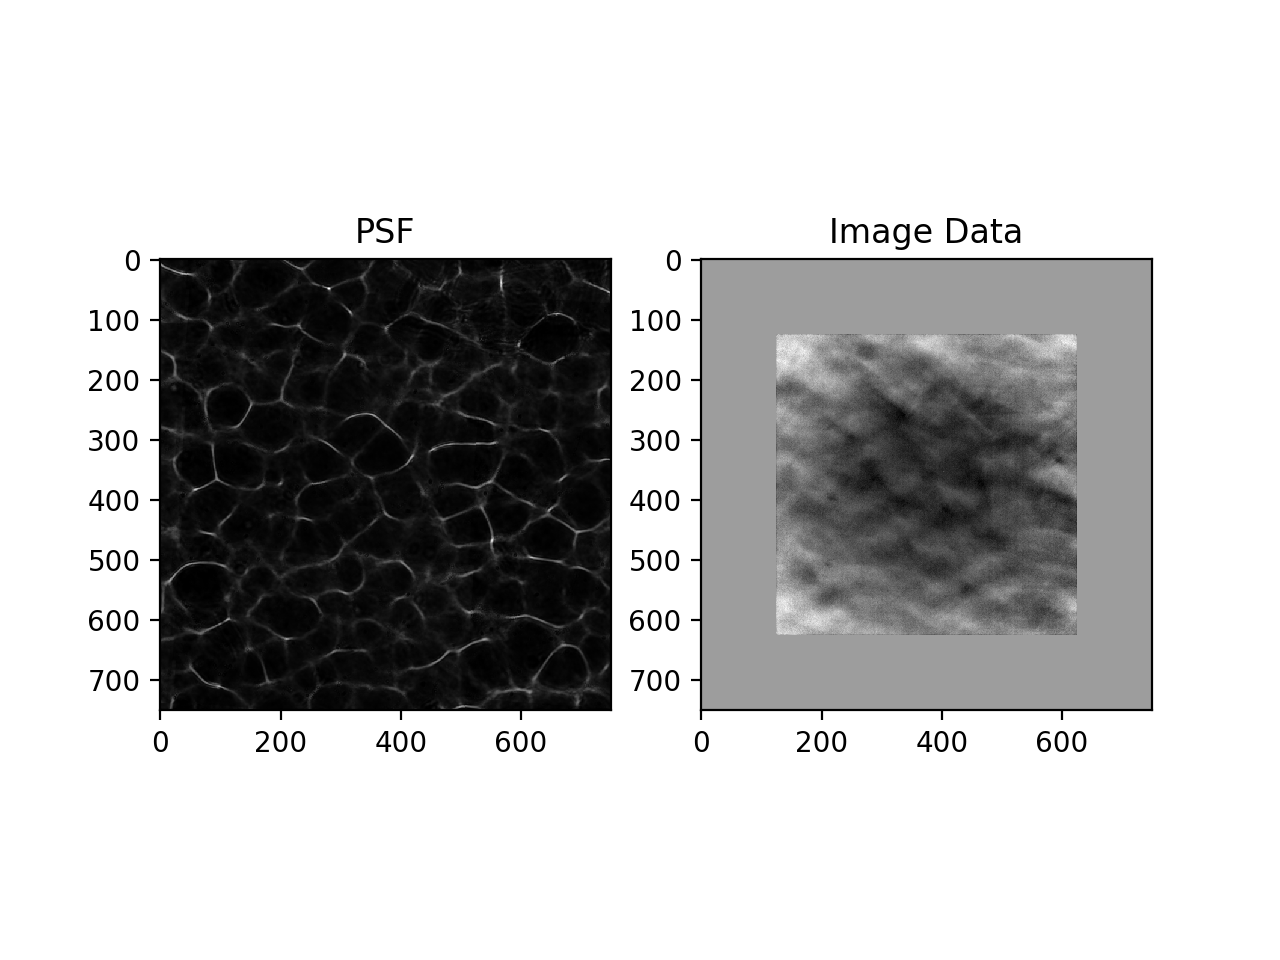

In [85]:
show_data(np.real(psf[:, :, 0]), b)

In [86]:
np.min(b)

0.378172588832489

In [87]:
#setup parameters
alg = 'admm'
max_itr = 200
opt = Options(dimensions, alg, max_itr)
#opt.gamma = np.real(1.8 / np.max(Hstar * H))
opt.gamma = 1
#opt.eps = 7.4e-3        #7.4e-3 for nesterov, 4e-3 for fista
opt.del_pixels = True
opt.psf = h
opt.b = b
opt.crop2d, opt.pad2d = crop2d, pad2d
opt.crop3d, opt.pad3d = crop3d, pad3d
opt.up_shape, opt.pad_shape = up_shape, obj_shape
opt.autotune = True
opt.beta = 1.1
opt.alpha = 1.01

# tune regularization parameters.
# 2d tuning: default to 1e-4 on each, tau = 2e-3
# cartoony: 1e-3, 5e-2, 1e-3, 2e-5
# to actually see cost function going down, use tau = 1, other mu's = 1e-4
opt.mu1 = 1e-4
opt.mu2 = 1e-4
opt.mu3 = 1e-4
opt.tau = 2e-4

In [88]:
grad_func = lambda x : grad(x, A, AH, b)
error = lambda x : objective(x, A, b, opt.tau)

<IPython.core.display.Javascript object>


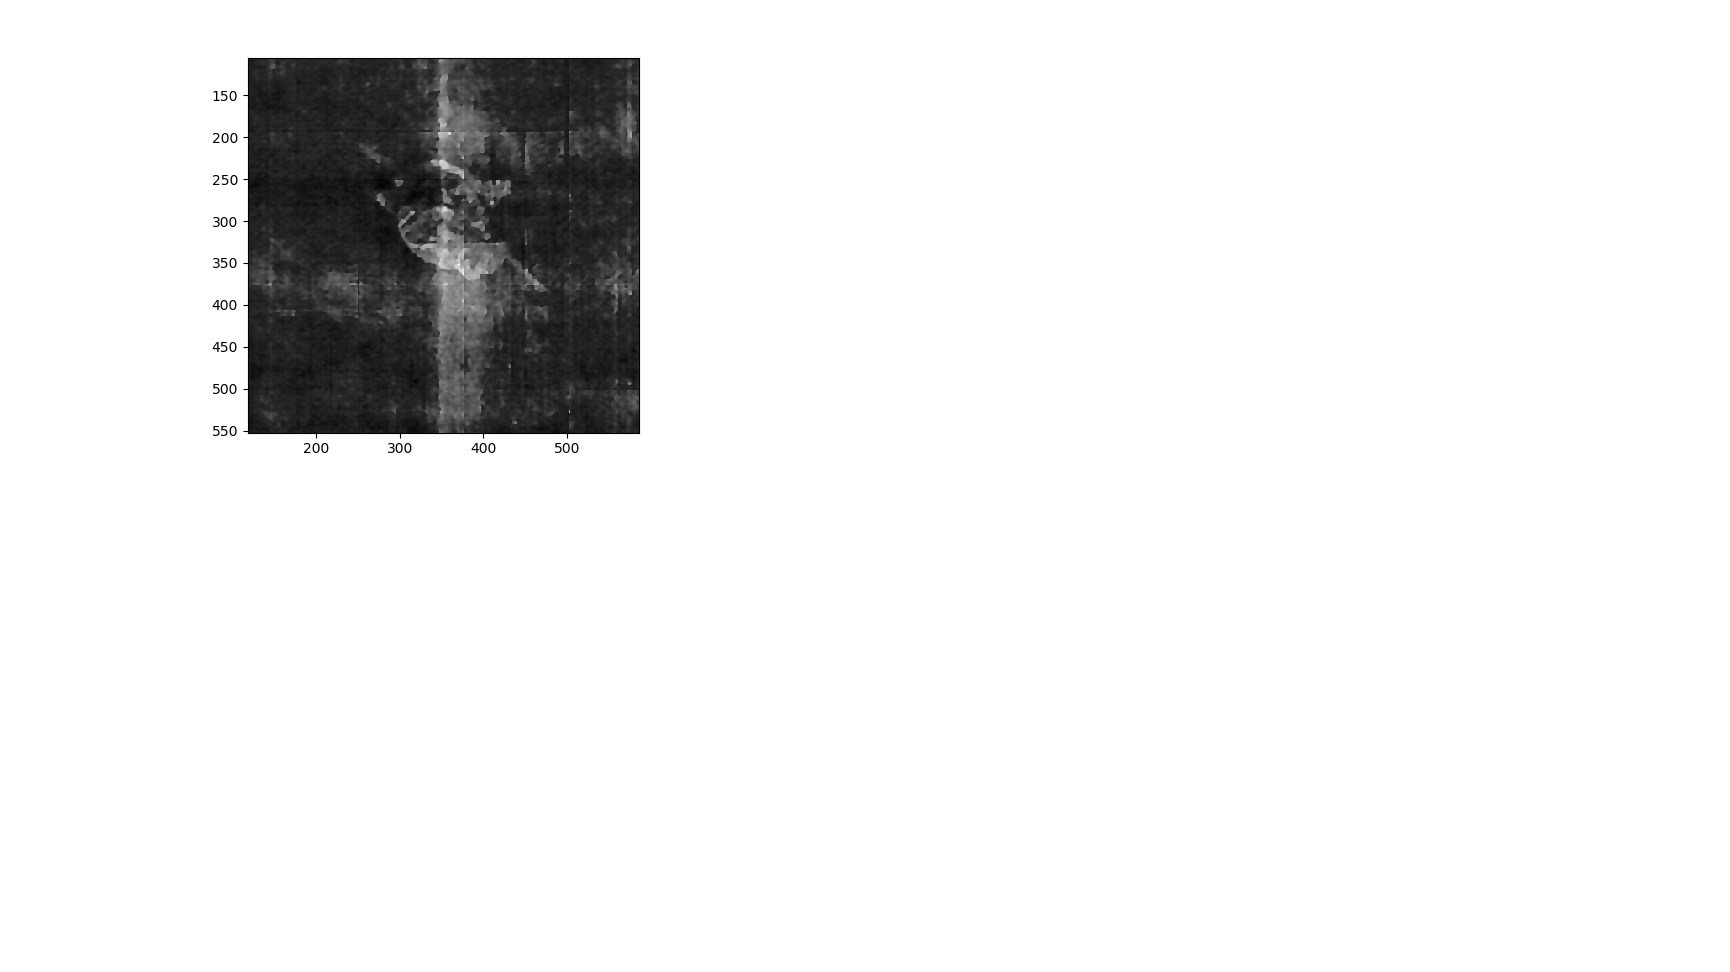

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.0002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


TypeError: Cannot handle this data type

In [89]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

from PIL import Image
im = Image.fromarray(x)
im.save("froggy.png")

<IPython.core.display.Javascript object>


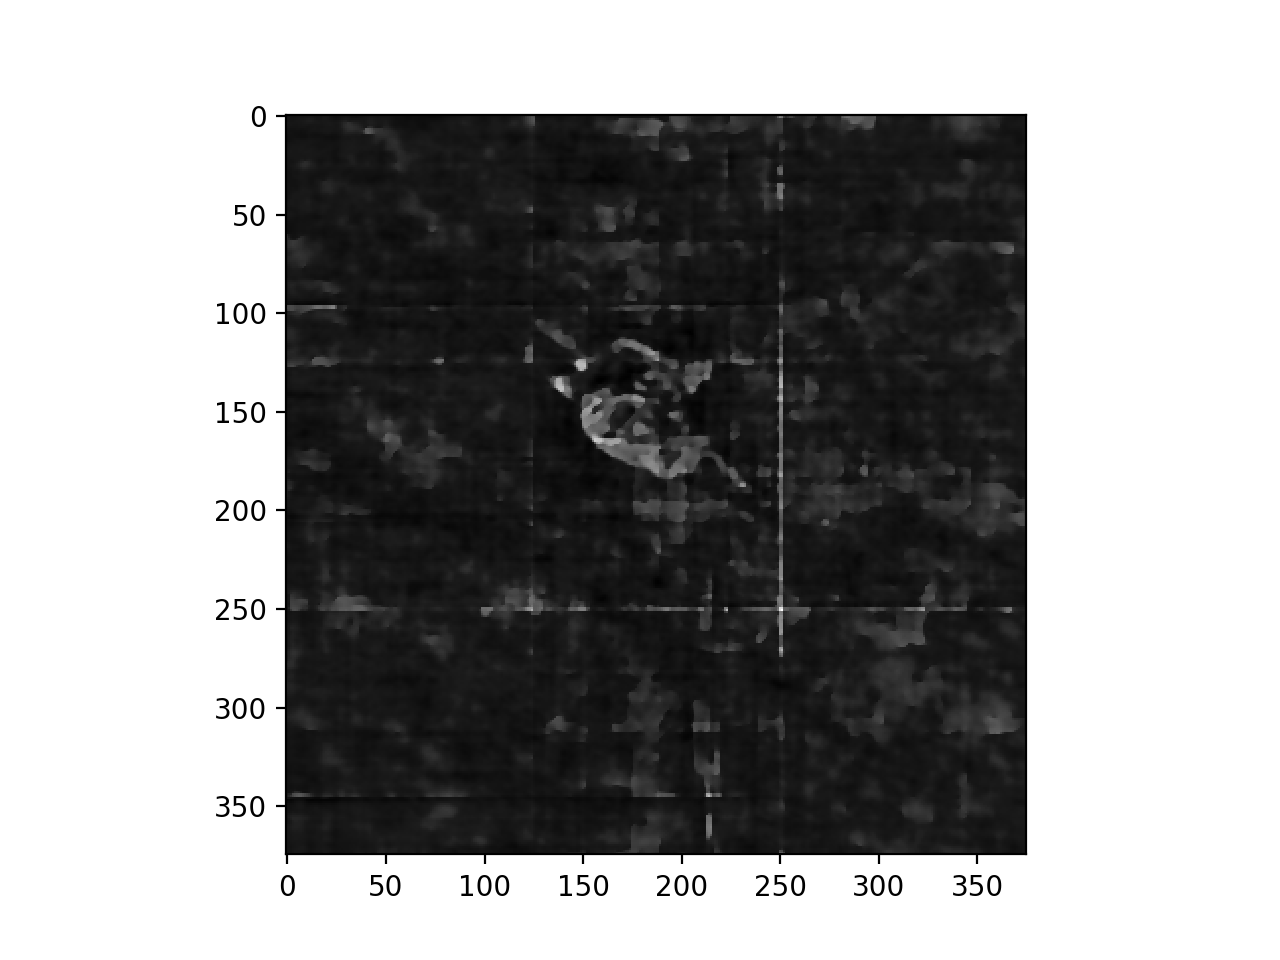

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.0002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [65]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


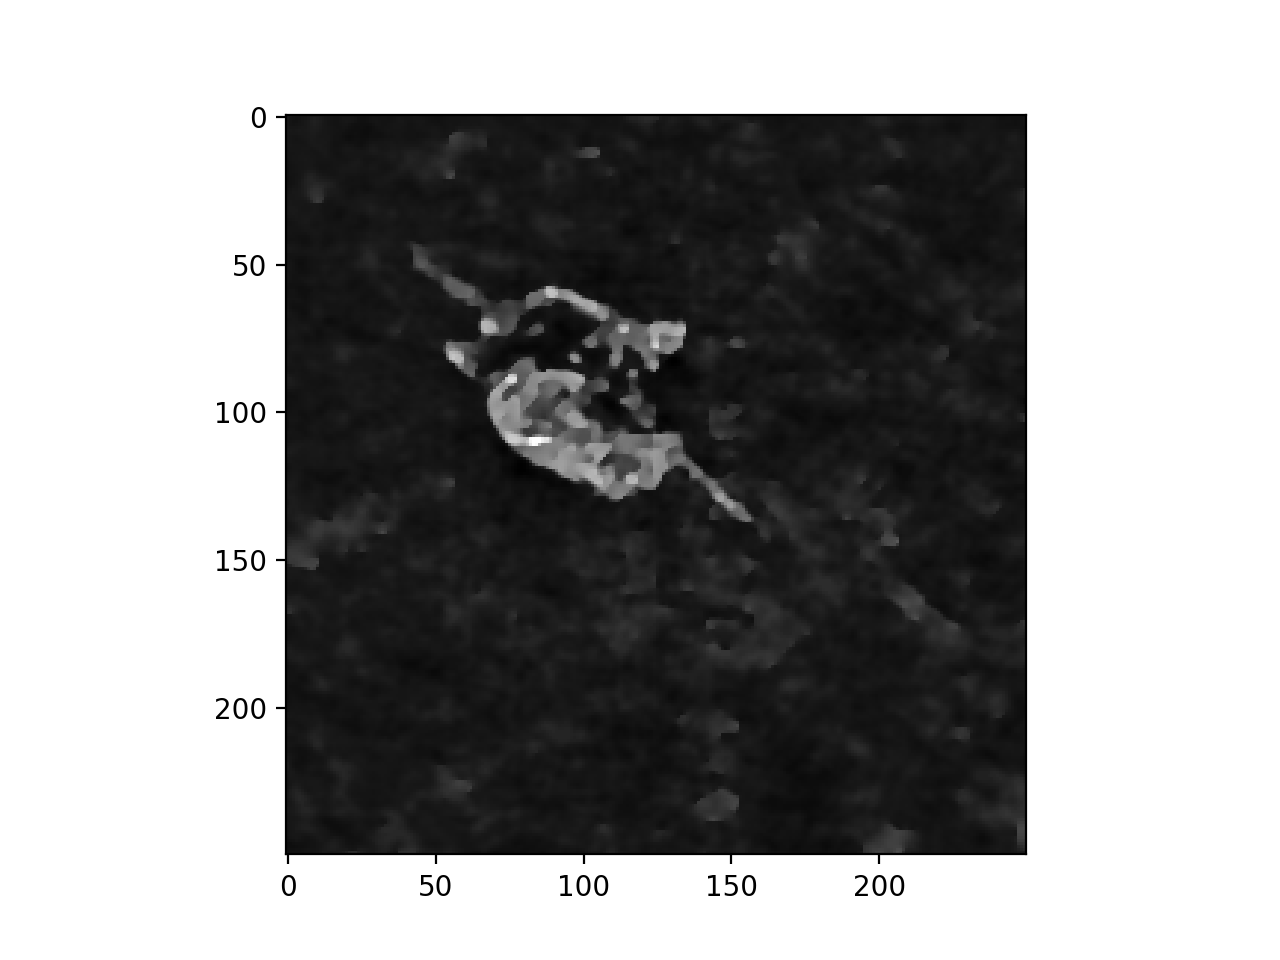

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [18]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


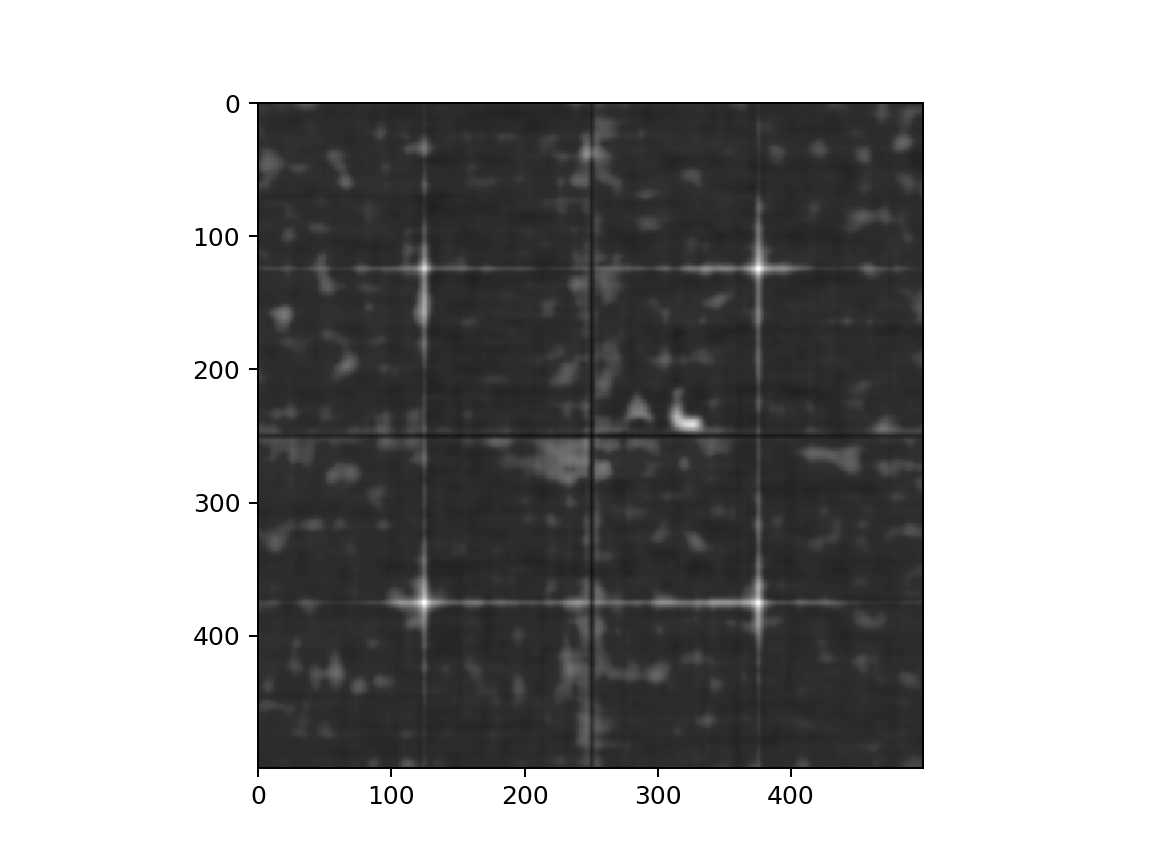

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [243]:
# Larger PSF (2000) recon
# psf = PSF_2000.png
# image = measurement.png

# psf_bg = 0
# image_bg = 0
# pad with min
# downsample by 4

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


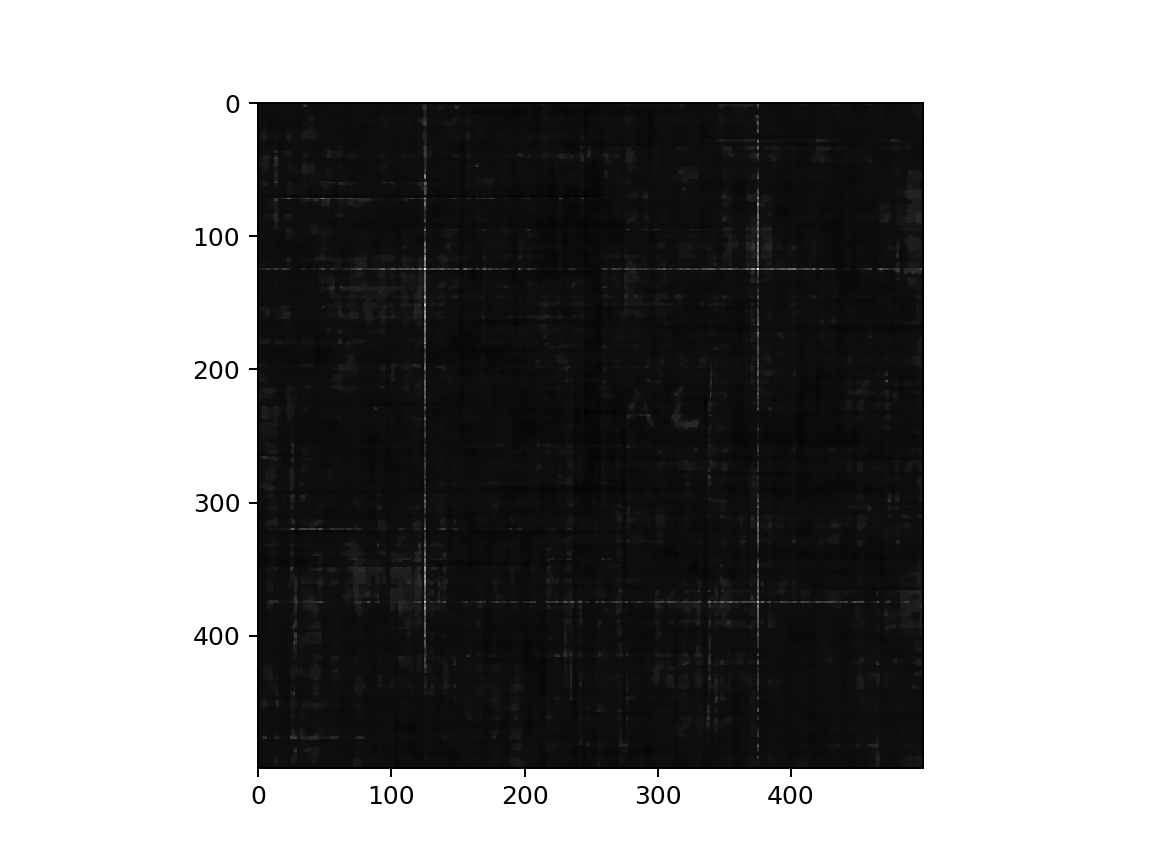

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [233]:
# Larger PSF (2000) recon
# psf = PSF_2000.png
# image = measurement.png

# psf_bg = np.mean(psf[5:15, 5:15])
# image_bg = np.mean(image[5:15, 5:15])
# pad with min
# downsample by 4

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


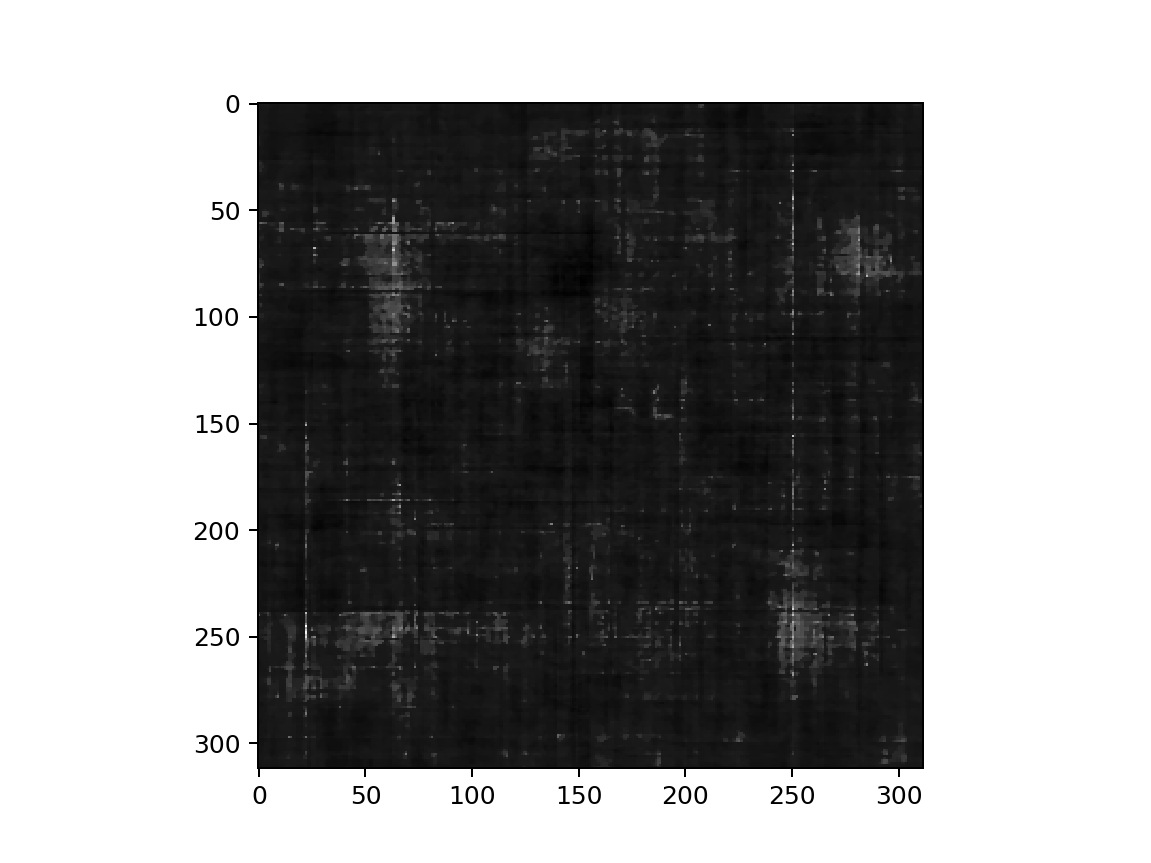

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [219]:
# Larger PSF (2500) recon
# psf = PSF_2500.png
# image = measurement.png

# psf_bg = np.mean(psf[5:15, 5:15])
# image_bg = np.mean(image[5:15, 5:15])
# padding with min of image
# downsample by 8 (?)

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


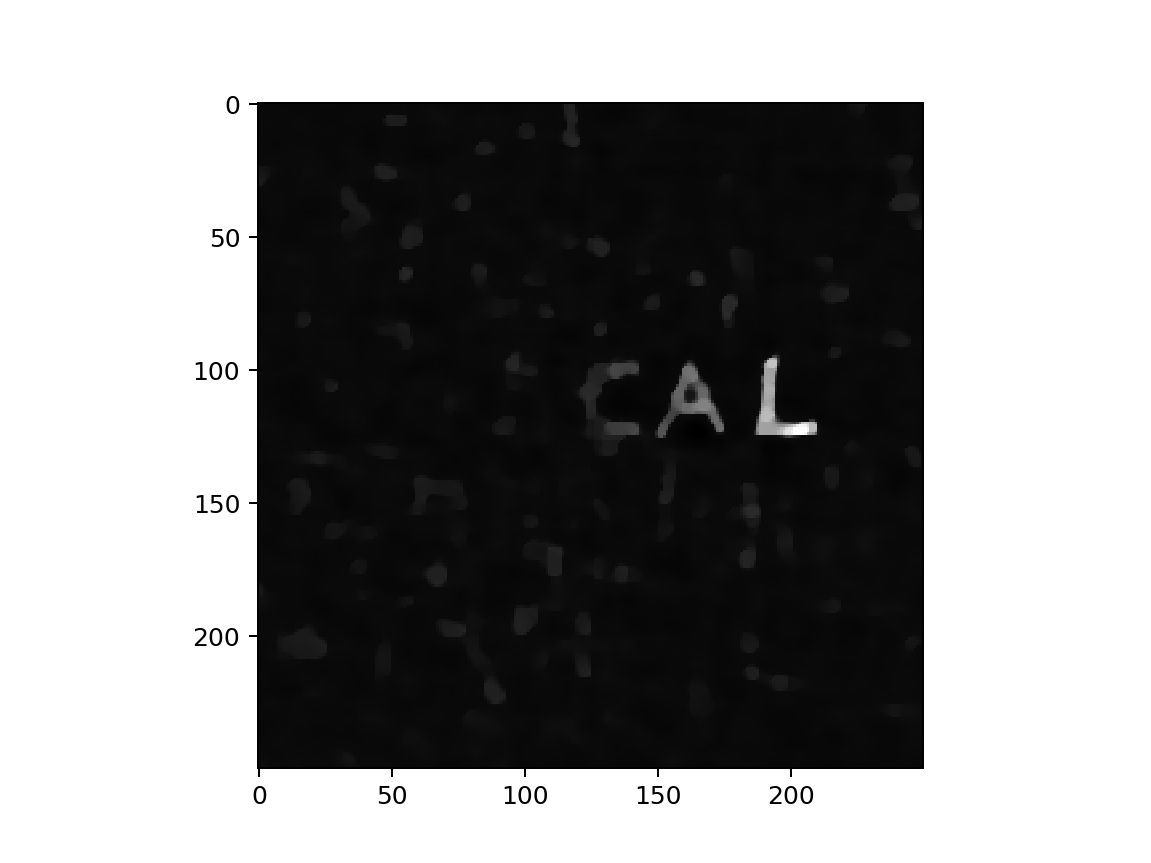

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [206]:
# Same size recon
# psf = singe_cam_PSF.png
# image = measurement.png

# psf_bg = np.mean(image[5:15, 5:15])
# image_bg = np.mean(image[5:15, 5:15])


x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


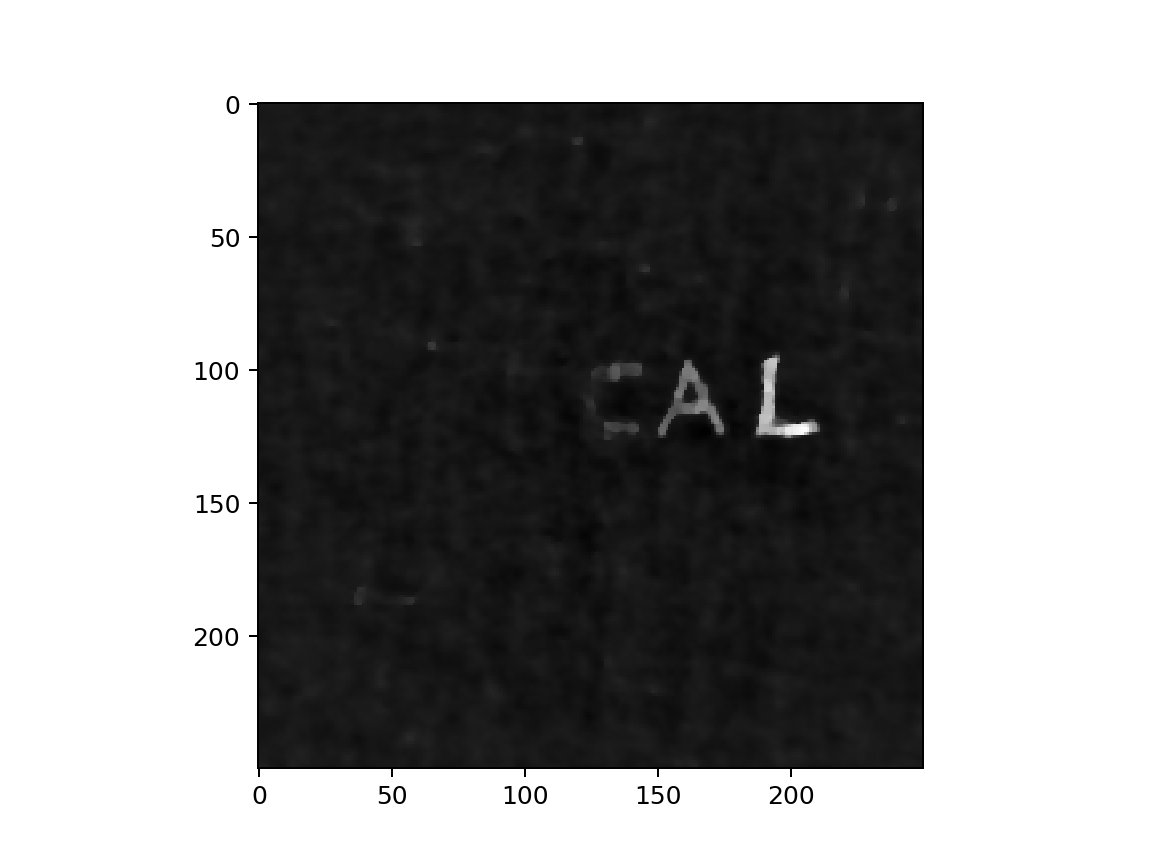

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [200]:
# Same size recon
# psf = singe_cam_PSF.png
# image = measurement.png

# psf_bg = np.mean(psf[5:15, 5:15])
# image_bg = np.mean(image[5:15, 5:15])

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


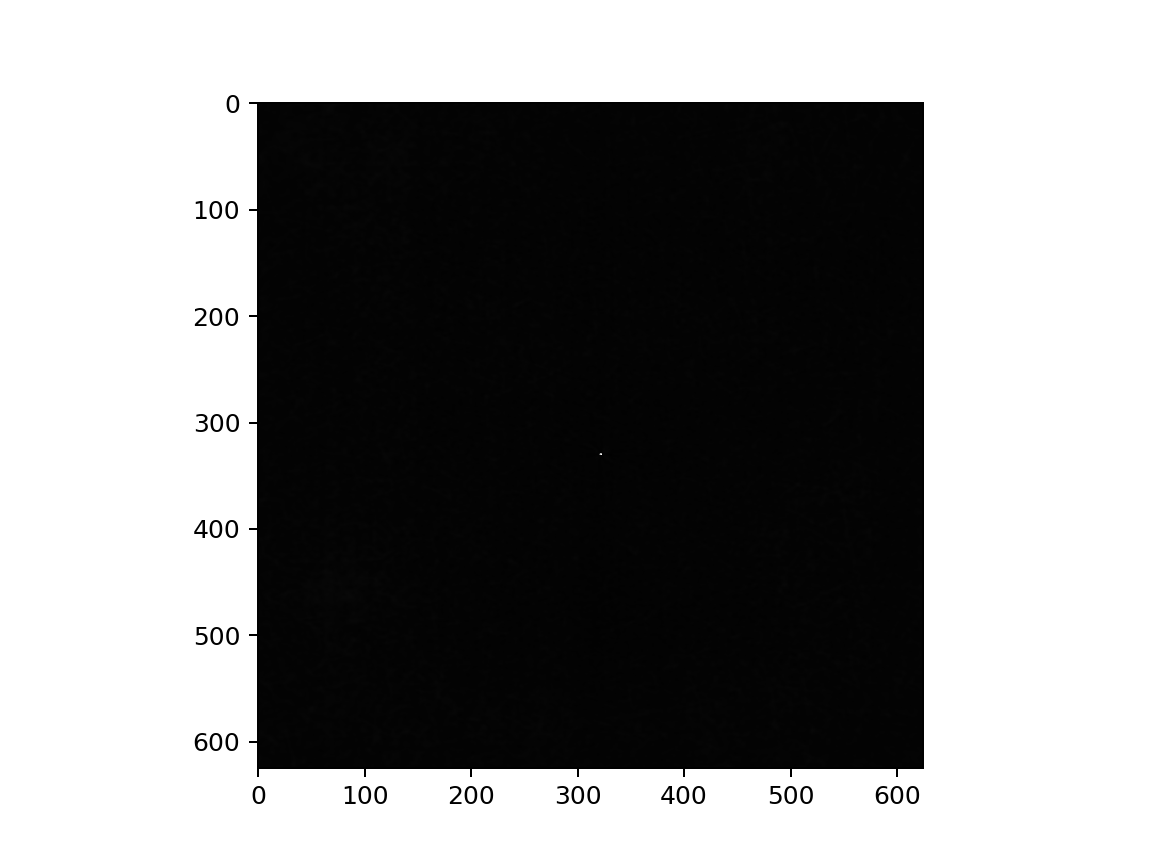

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [151]:
# Point source recon with larger PSF
# psf = PSF_2500.png
# image = PSF_single_cam.png

# psf_bg = image_bg = np.mean(image[5 : 15, 5 : 15])
# padding with min of image

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


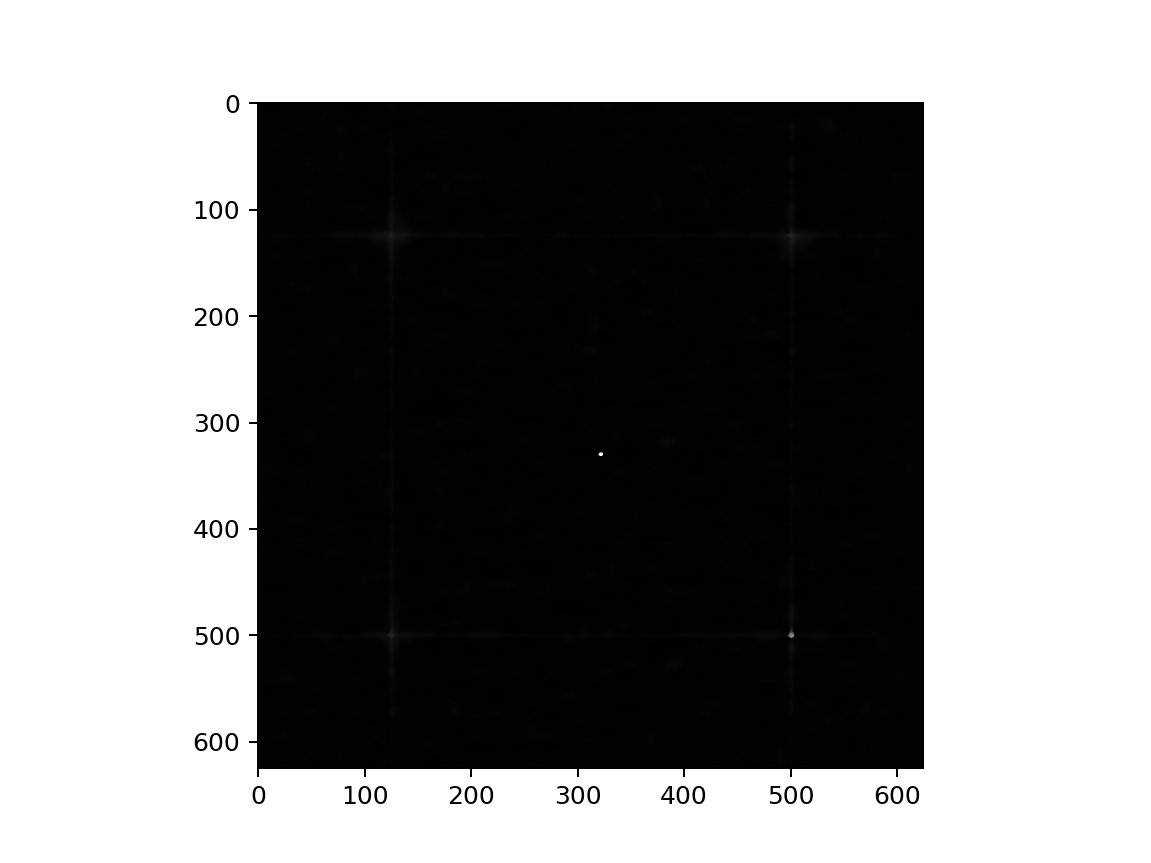

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [138]:
# Point source recon with larger PSF
# psf = PSF_2500.png
# image = PSF_single_cam.png

# no background subtraction, (psf_bg = 0, image_bg = 0)
# padding with 0.0

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


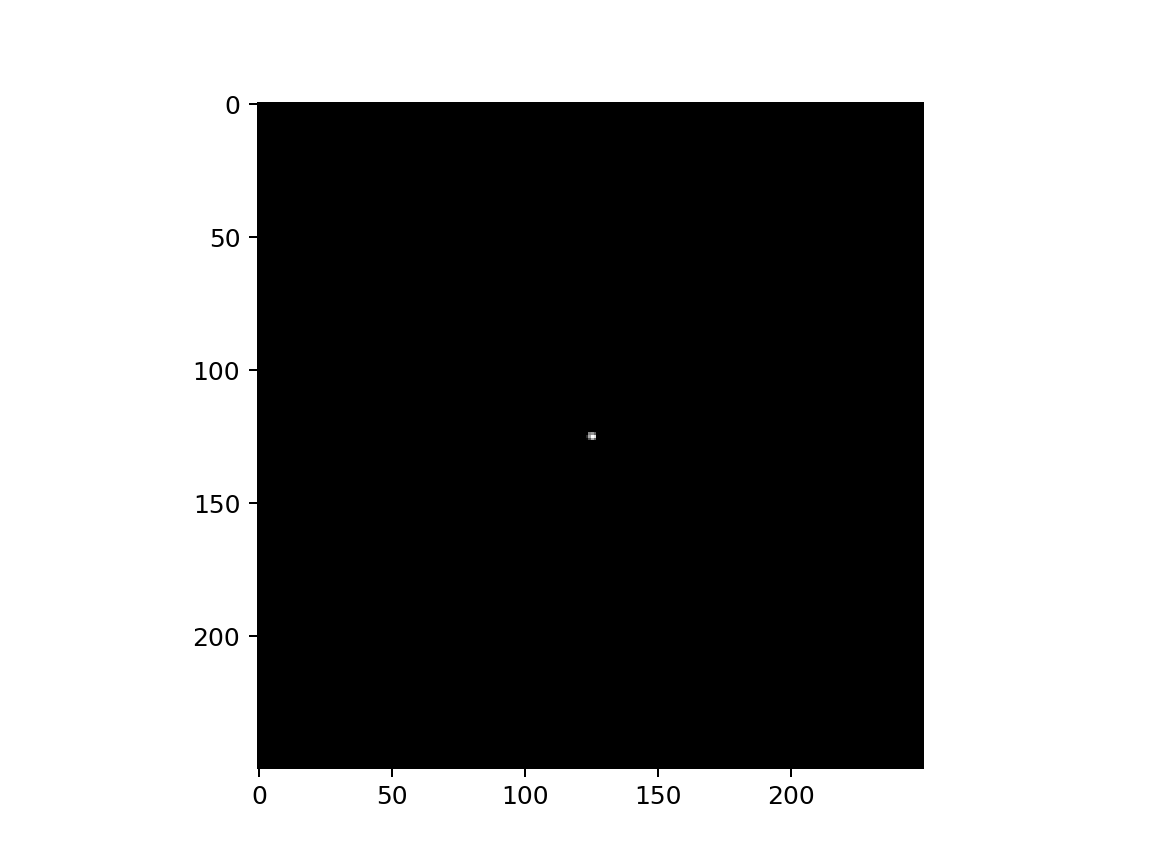

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [124]:
# Point source recon
# psf = PSF_single_cam.png
# image = PSF_single_cam.png

# no background subtraction, (psf_bg = 0, image_bg = 0)

x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)